In [230]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
sns.set_style("dark")

In [231]:
df=pd.read_csv('Mall_Customers.csv')

In [232]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Questions:
    1: Do Females have higher Spending Score than Males or it's the other way around?
    2: Which age group has higher spending score?
    3: What is the distribuation of Age group with Gender based on the average of their spending score?

## Question 1: Do Females have higher Spending Score than Males or it's the other way around?

In [233]:
total=df.groupby(['Gender'],as_index=False)['Spending Score (1-100)'].sum()
mean=df.groupby(['Gender'],as_index=False)['Spending Score (1-100)'].mean()
df_all_gender=total.merge(mean,on='Gender',suffixes=['_Total','_Mean'])
df_all_gender

,Gender,Spending Score (1-100)_Total,Spending Score (1-100)_Mean
0,Female,5771,51.526786
1,Male,4269,48.511364


In [234]:
x=df.Gender.value_counts()
x

Female    112
Male       88
Name: Gender, dtype: int64

In [235]:
population=(x[0]/df.Gender.count())-(x[1]/df.Gender.count())
population

0.12000000000000005

### Answer 1: We can't say for sure since there is a 12% difference in the popluation where Females is higher than Males but if disregard that we can say that Females tend to have higher spending score than Males

## Question 2: Which age group has higher spending score?

In [213]:
df['Age_Bucket']=''

for x in df.itertuples():
    if (x.Age >=18) &(x.Age<=23):
        df.at[x.Index,'Age_Bucket']='18-23'
    
    elif (x.Age >=24) &(x.Age<=29):
        df.at[x.Index,'Age_Bucket']='24-29'
        
    elif (x.Age >=30) &(x.Age<=35):
        df.at[x.Index,'Age_Bucket']='30-35'
        
    elif (x.Age >=36) &(x.Age<=41):
        df.at[x.Index,'Age_Bucket']='36-41'
        
    elif (x.Age >=42) &(x.Age<=47):
        df.at[x.Index,'Age_Bucket']='42-47'
        
    elif (x.Age >=48) &(x.Age<=53):
        df.at[x.Index,'Age_Bucket']='48-53'
    elif x.Age>=54:
        df.at[x.Index,'Age_Bucket']='>=54'

In [214]:
age_bucket=df.groupby('Age_Bucket',as_index=False)['Spending Score (1-100)'].mean()
age_bucket

,Age_Bucket,Spending Score (1-100)
0,18-23,54.290323
1,24-29,64.125000
2,30-35,63.558140
3,36-41,51.346154
4,42-47,27.052632
5,48-53,40.086957
6,>=54,38.647059


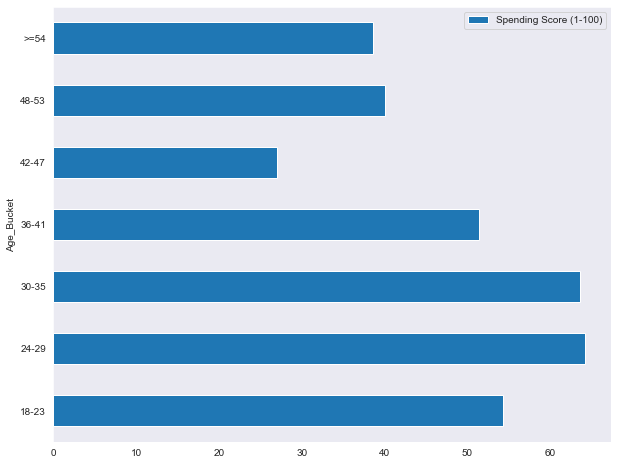

In [215]:
age_bucket.plot(kind="barh",x='Age_Bucket',y='Spending Score (1-100)',figsize=(10,8))

In [216]:
df.Age_Bucket.value_counts()

30-35    43
>=54     34
18-23    31
36-41    26
24-29    24
48-53    23
42-47    19
Name: Age_Bucket, dtype: int64

### Answer 2: We can see that customers witihin the Age group of 24-29 and 30-35 tend to have higher spending score than the rest of the Age groups.

## Question 3: What is the distribuation of Age group with both Genders based on the average of their spending score?

In [217]:
age_bucket_female=df[df['Gender']=='Female'].groupby(['Age_Bucket','Gender'],as_index=False)['Spending Score (1-100)'].mean()
age_bucket_male=df[df['Gender']=='Male'].groupby(['Age_Bucket','Gender'],as_index=False)['Spending Score (1-100)'].mean()

age_bucket_gender=pd.concat([age_bucket_male,age_bucket_female],join='inner',keys='Age_Bucket')
age_bucket_gender=age_bucket_gender.reset_index(drop=True)

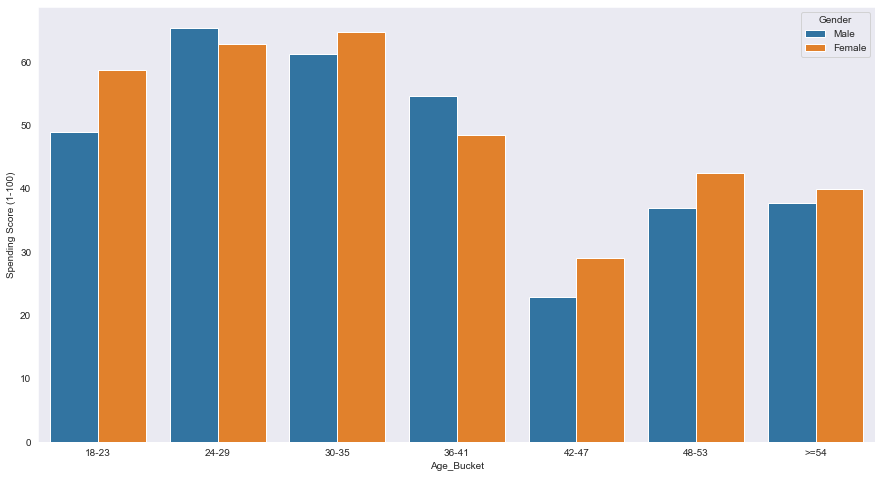

In [218]:
plt.figure(figsize=(15,8))
sns.barplot(data=age_bucket_gender,x='Age_Bucket',y='Spending Score (1-100)',hue='Gender')

### Answer 3: We can see that females tend to have higher spending score in almost all of the Age groups except 2.

In [219]:
k=range(1,12)
lis=[]
df_s=df[['Annual Income (k$)','Spending Score (1-100)']]
for i in k:
    kmeans=cluster.KMeans(n_clusters=i,init='k-means++')
    kmeans=kmeans.fit(df_s)
    iteration=kmeans.inertia_
    lis.append(iteration)

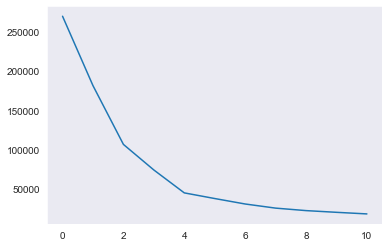

In [220]:
plt.plot(lis)

### We can find from the elbow method that the best amount of clusters is 5 clusters

In [221]:
kmeans=cluster.KMeans(n_clusters=5,init='k-means++')
df_s=df[['Annual Income (k$)','Spending Score (1-100)']]
kmeans=kmeans.fit(df_s)
df['clusters']=kmeans.labels_

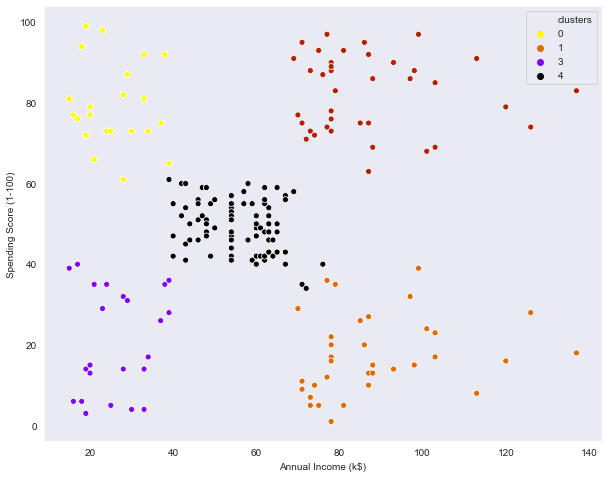

In [228]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue='clusters',data=df, palette="gnuplot_r")

### When we divided the customers into 5 segments now we can know what are the best segments to target and what are the segments that we need to stay away from. Like we can spend good resources to target cluster 3 and increase their spending score.